In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from conductor.knowledge import pdf

import pathlib


knowledge_dir = pathlib.Path("../+knowledge/")
knowledge_filenames = [
    str(p)
    for p in knowledge_dir.iterdir()
    if p.suffix in ['.pdf']
]
display(knowledge_filenames)

['../+knowledge/Liao_text_2017-Industrial_biotechnology.pdf',
 '../+knowledge/Ratledge and Kristiansen - 2006 - Basic biotechnology.pdf',
 '../+knowledge/VitaminB12_March_2024.pdf',
 '../+knowledge/Lactoferrin_August_2024.pdf',
 '../+knowledge/41467_2022_Article_32296.pdf',
 '../+knowledge/s41467-022-32296-y.pdf',
 '../+knowledge/main.pdf']

In [3]:
#utilities
def get_contents_pagerange(doc)->tuple[int]:
    """find the table of contents pages"""
    return (5,22)

def pagerange_to_pagenums(pagerange):
    pagenums = range(pagerange[0], pagerange[1]+1)
    return list(pagenums)

def get_page_text(doc, pagenum):
    return doc[pagenum].get_text()


In [4]:
# Global metrics assessment
import matplotlib.pyplot as plt
def get_new_ax(figsize=(5,3)):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    plt.close()
    return ax

def describe_document(doc, plot_kwargs={}):
    
    global_metadata = pdf.get_global_metadata(doc)

    pagenums = global_metadata['pagenums']
    wordcounts = global_metadata['wordcounts']
    lettercounts = global_metadata['lettercounts']

    #Inspect the blank page thresholds
    thresholds, blankpage_counts = pdf.get_blankpage_counts_by_threshold(
        wordcounts, 
        lower_threshold=0, 
        upper_threshold=100, 
        step=10
    )

    ###### plotting
    figsize = plot_kwargs.get('figsize', (5,3))
    linestyle = plot_kwargs.get('linestyle','-')
    linewidth = plot_kwargs.get('linewidth',1)
    color = plot_kwargs.get('color', '#1e5a3e') 
    edgecolor = plot_kwargs.get('edgecolor',"#FFFFFF")
    marker = plot_kwargs.get('marker',".")

    #blank pages by threshold
    ax = get_new_ax(figsize)
    ax.plot(
        thresholds, blankpage_counts,
        color=color,
        linestyle=linestyle, linewidth=linewidth,
        marker=marker,
    )
    ax.set(
        title="Blank page count versus wordcount threshold for blank",
        xlabel='Word Count', 
        ylabel='# Blank Pages'
    )
    fig_blankpage_thresholds = ax.figure

    #Word count page distribution
    ax = get_new_ax(figsize)
    bins = int(len(wordcounts)/10)
    bins = 10 if bins==1 else bins
    ax.hist(
        wordcounts, bins=bins, 
        color=color, edgecolor=edgecolor
    )
    ax.set(
        title="Distribution of words per page",
        xlabel='Word Count / Page', 
        ylabel='# of Pages'
    )
    fig_wordcount_distribution = ax.figure

    #wordcounts by page
    if len(pagenums)>100:
        #turn off marker
        marker=' '
    ax = get_new_ax(figsize)
    ax.plot(
        pagenums, wordcounts,
        color=color,
        linestyle=linestyle, linewidth=linewidth, 
        marker=marker,
    )
    ax.set(
        title="Wordcount by page number",
        xlabel='Page Number',
        ylabel='Word Count'
    )
    fig_wordcounts = ax.figure


    ### display figures
    display(fig_blankpage_thresholds)
    display(fig_wordcount_distribution)
    display(fig_wordcounts)

    ###Return diagnostic
    return thresholds, blankpage_counts

# Analyze global metrics (preparsing)

- use this information to identify parsing logic
    - journal has immediate pages (identify journal using LLM) and no blank pages
    - textbook has long pages and blank page profiles that are not flat
- for text book use blank pages to delineate search for key information:
    - title and author
    - table of contents

In [5]:
from conductor.knowledge import pdf

In [6]:
file_path = "../+knowledge/Liao_text_2017-Industrial_biotechnology.pdf"
doc = pdf.load_pdf(file_path)

pagenums = pdf.get_pagenums(doc)
wordcounts = pdf.get_wordcounts(doc)
lettercounts = pdf.get_lettercounts(doc)
blankpages = pdf.get_blankpages_by_wordcounts(wordcounts, threshold=50)
blankpage_count = pdf.blankpages_count(blankpages)
thresholds, blankpage_counts = pdf.get_blankpage_counts_by_threshold(wordcounts)
global_metadata = pdf.get_global_metadata(doc)

## Textbook

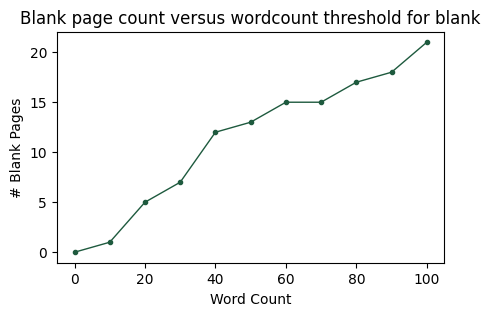

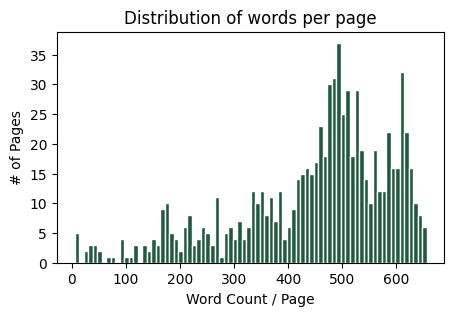

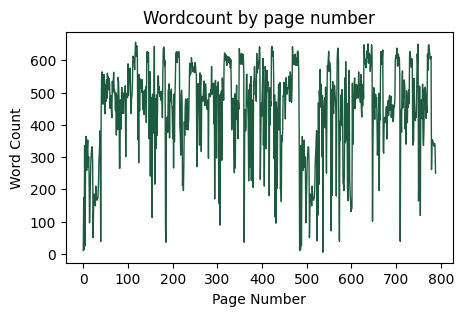

In [7]:
file_path = "../+knowledge/Liao_text_2017-Industrial_biotechnology.pdf"
doc = pdf.load_pdf(file_path)

global_metadata = pdf.get_global_metadata(doc)
thresholds, blankpage_counts = describe_document(doc, plot_kwargs={})

## Journal

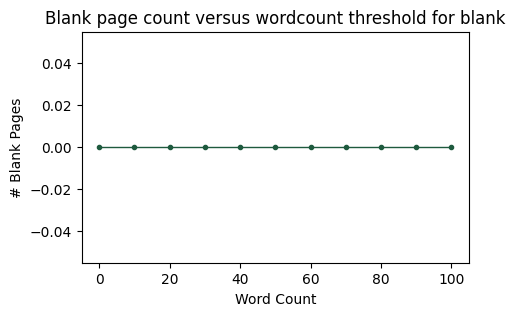

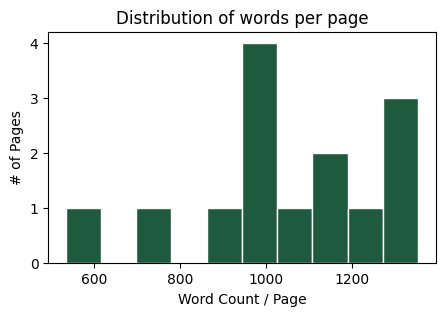

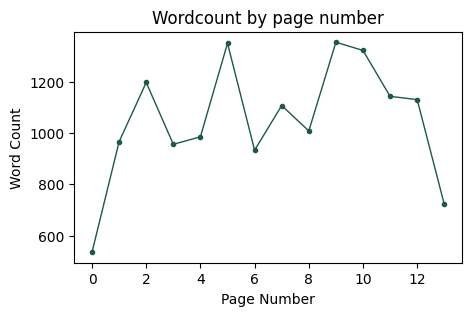

In [8]:
file_path = "../+knowledge/41467_2022_Article_32296.pdf"
doc = pdf.load_pdf(file_path)

global_metadata = pdf.get_global_metadata(doc)
thresholds, blankpage_counts = describe_document(doc, plot_kwargs={})

## Analyze Metadata Metrics (parsing sections)
- next we will identify sections of the documents that need specific logic based parsing

**textbooks**
- identify the table of contents
- use the table of contents to find the page numbers of chapters, etc.
- identify any figure numbers?

**journal**
- identify the journal and citation
- identify the abstract
- identify the main sections of the journal (methods, results, etc)


In [9]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if openai_api_key and anthropic_api_key:
   print("API key loaded successfully!")
else:
   print("Failed to load API key. Check your .env file.")

API key loaded successfully!


## Journal

In [10]:
from conductor.knowledge import journal

In [11]:
file_path = "../+knowledge/41467_2022_Article_32296.pdf"
doc = pdf.load_pdf(file_path)
global_metadata = pdf.get_global_metadata(doc, threshold=200)

## Global metadata

In [12]:
title = journal.identify_article_title(doc)
display(title)
publisher = journal.identify_article_publisher(doc)
display(publisher)
publishing_dates = journal.identify_publishing_dates(doc)
display(publishing_dates)
authors = journal.identify_article_authors(doc)
display(authors)
abstract = journal.identify_article_abstract(doc)
display(abstract)

{'title': 'Muconic acid production from glucose and xylose in Pseudomonas putida via evolution and metabolic engineering',
 'compeleteness': 'success'}

{'journal_name': 'Nature Communications', 'compeleteness': 'success'}

{'date_received': None,
 'date_accepted': None,
 'date_published': '2022-08-12',
 'completeness': 'warning'}

{'authors': ['Chen Ling',
  'George L. Peabody',
  'Davinia Salvachúa',
  'Young-Mo Kim',
  'Colin M. Kneucker',
  'Christopher H. Calvey',
  'Michela A. Monninger',
  'Nathalie Munoz Munoz',
  'Brenton C. Poirier',
  'Kelsey J. Ramirez',
  'Peter C. St. John',
  'Sean P. Woodworth',
  'Jon K. Magnuson',
  'Kristin E. Burnum-Johnson',
  'Adam M. Guss',
  'Christopher W. Johnson',
  'Gregg T. Beckham'],
 'completeness': 'success'}

{'abstract_page': 1,
 'abstract': 'Muconic acid is a bioprivileged molecule that can be converted into direct replacement chemicals for incumbent petrochemicals and performance-advantaged bioproducts. In this study, Pseudomonas putida KT2440 is engineered to convert glucose and xylose, the primary carbohydrates in lignocellulosic hydrolysates, to muconic acid using a model-guided strategy to maximize the theoretical yield. Using adaptive laboratory evolution (ALE) and metabolic engineering in a strain engineered to express the D-xylose isomerase pathway, we demonstrate that mutations in the heterologous D-xylose:H+ symporter (XylE), increased expression of a major facilitator superfamily transporter (PP_2569), and overexpression of aroB encoding the native 3-dehydroquinate synthase, enable efficient muconic acid production from glucose and xylose simultaneously. Using the rationally engineered strain, we produce 33.7 g L−1 muconate at 0.18 g L−1 h−1 and a 46% molar yield (92% of the ma

## Document Structure

In [16]:
from conductor.knowledge import journal_sections
pages = {
    'title' : doc[0],
    'first' : doc[1],
    'second' : doc[2],
}
page_blocks = {
    name : page.get_text("dict")["blocks"]
    for name, page in pages.items()
}


In [17]:
page_name = 'second'
page = pages[page_name]
blocks = page_blocks[page_name]
print(f"Blocks: {len(blocks)}")
block_analyzer = journal_sections.BlockAnalyzer(window_size=100, use_word_count=False)

Blocks: 35


In [49]:
block = blocks[0]
lines = block["lines"]
fontsizes = [
    line['spans'][0]['size'] 
    for line in lines
]
# words = [span for line in block["lines"] for span in line["spans"]]
fontsizes

[8.219099998474121,
 8.219099998474121,
 8.219099998474121,
 8.219099998474121,
 8.219099998474121,
 8.219099998474121,
 8.219099998474121]

In [51]:
block = blocks[0]
text_groups_block = block_analyzer.analyze_with_fontproperties(block)
display(text_groups_block)

[]

In [32]:
block = blocks[0]
block_analyzer = journal_sections.BlockAnalyzer(window_size=100, use_word_count=False)
text_groups, avg_font_size = block_analyzer.analyze(block)
text_groups[0]

AttributeError: 'BlockAnalyzer' object has no attribute 'analyze'

([<conductor.knowledge.journal_sections.TextGroup at 0x7fdea5b0dd20>,
 8.219099998474121)

In [ ]:

for block in blocks:
    if block["type"] == 0:  # Text block
        text_groups, avg_font_size = self.block_analyzer.analyze(block)
        sections = self._process_text_groups(text_groups, avg_font_size, page_num)
        all_sections.extend(sections)
    if block["type"] == 1: # Image
        continue

In [16]:
from conductor.knowledge import journal_sections
rules = [
        journal_sections.SingleWordRule(),
        journal_sections.LengthRule(),
        journal_sections.TitleCaseRule(),
        journal_sections.KeywordRule(['introduction', 'method', 'result', 'discussion', 'conclusion', 'reference', 'abstract']),
        journal_sections.NumberingPatternRule(),
        journal_sections.FontSizeRule(),
        journal_sections.FontStyleRule()
    ]
rule_engine = journal_sections.RuleEngine(rules)
block_analyzer = journal_sections.BlockAnalyzer(window_size=100, use_word_count=False)
section_identifier = journal_sections.SectionIdentifier(rule_engine, block_analyzer)

sections = section_identifier.identify_sections(doc)
print(f"Number of sections: {len(sections)}")
# Print identified sections
# for section in sections:
#     print(f"Page {section['page_num'] + 1}: {section['text']}")

Number of sections: 2220


In [19]:
from conductor.knowledge import journal_functional
# Compose rules
rule = journal_functional.compose_rules(
    journal_functional.single_word_rule,
    journal_functional.length_rule(),
    journal_functional.title_case_rule,
    journal_functional.keyword_rule(['introduction', 'method', 'result', 'discussion', 'conclusion', 'reference', 'abstract']),
    journal_functional.numbering_pattern_rule,
    journal_functional.font_size_rule(),
    journal_functional.font_style_rule
)

sections = journal_functional.process_document(doc, window_size=100, use_word_count=False, rule=rule)

print(f"Number of sections: {len(sections)}")
# Print identified sections
# for section in sections:
#     print(f"Page {section.page_num + 1}: {section.text}")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdf40f17eb0>>
Traceback (most recent call last):
  File "/home/nicholasgrundl/miniconda3/envs/conductor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

## Textbook

In [179]:
import instructor
import pydantic



In [ ]:
import anthropic

def analyze_page_range(doc, metadata, start_page, end_page, page_description):
    """
    Analyze a range of pages to find the probability of each page matching the description.
    
    :param doc: fitz.Document object
    :param metadata: dict with document metadata
    :param start_page: int, starting page number (0-indexed)
    :param end_page: int, ending page number (0-indexed)
    :param page_description: str, description of the page type to find
    :return: dict with page probabilities
    """
    page_range_text = {
        i: metadata["pages"][i] for i in range(start_page, end_page + 1)
    }
    
    client = anthropic.Client(os.environ.get("ANTHROPIC_API_KEY"))
    
    system_message = """
    You are an expert text parser and librarian. Your task is to analyze the given text from a document and determine the probability that each page matches the provided description. Please read all the JSON text carefully and reflect on it before proceeding with your analysis.
    """
    
    human_message = f"""
    Here is the JSON containing the text from a range of pages in a document:
    
    {json.dumps(page_range_text, indent=2)}
    
    Please analyze each page and determine the probability that it matches the following description:
    
    {page_description}
    
    Return your analysis as a JSON object where the keys are page numbers and the values are the probabilities (as floats between 0 and 1) that the page matches the description.
    """
    
    response = client.completion(
        prompt=f"{system_message}\n\nHuman: {human_message}\n\nAssistant:",
        model="claude-v1",
        max_tokens_to_sample=1000,
        stop_sequences=["\nHuman:"],
        temperature=0
    )
    
    # Parse the JSON response
    try:
        probabilities = json.loads(response['completion'].strip())
    except json.JSONDecodeError:
        print("Error: Unable to parse JSON response from Claude")
        probabilities = {}
    
    return probabilities

In [42]:

contents_pagerange = get_contents_pagerange(doc)
contents_pagenums = pagerange_to_pagenums(contents_pagerange)
contents_pagenums

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [43]:
print(get_page_text(doc,22))

XIV
Contents
19.3.6
Engineering Protein Folding and Secretion Pathways to Enhance
Productivity
701
19.3.7
Protein Glycosylation and Glycoengineering
703
19.3.8
Recombinant Proteins on the Market
703
19.4
Application of P. pastoris for Metabolite Production
703
19.5
Conclusion
705
References
705
Index
715



In [37]:
pagenums = contents_pagenums
page_content = {}
for pagenum in pagenums:
    page = doc[pagenum]
    content = page.get_text()
    page_content[pagenum] = content
print(page_content[contents_pagenums[0]])
print("-------------")
print(page_content[contents_pagenums[1]])

VII
Contents to Volume 1
List of Contributors
XVII
About the Series Editors
XXIX
Preface
XXXI
Part I
Industrial Biotechnology: From Pioneers to Visionary
1
1
History of Industrial Biotechnology
3
Arnold L. Demain, Erick J. Vandamme, John Collins, and Klaus Buchholz
1.1
The Beginning of Industrial Microbiology
3
1.2
Primary Metabolites and Enzymes
7
1.2.1
Birth, Rise, and Decline of the Term “Biotechnology” in the Period
1900–1940
7
1.2.2
Inﬂuential Scholars Boosting Industrial Fermentation from 1900 to
1940
8
1.2.3
Milestone Achievements in Industrial Fermentation Technology
10
1.2.3.1
The Acetone–Butanol–Ethanol (ABE) Fermentation Process
10
1.2.3.2
A Novel Vitamin C Fermentation Process
11
1.2.3.3
The Lactic Acid Fermentation Process
11
1.2.3.4
Fermentative Production of Glycerol
12
1.2.3.5
L-(−)-Ephedrine by Fermentation
12
1.2.3.6
Steroid Transformations
13
1.2.3.7
The Citric Acid Fermentation Process
13
1.2.3.8
Gluconic Acid Process
13
1.2.3.9
Other Important Fermentation Processe

In [ ]:
for page_num in range(len(doc)):
    page = doc[page_num]

In [17]:
doc.metadata

{'format': 'PDF 1.4',
 'title': '',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': '',
 'producer': 'iText® 5.5.2 ©2000-2014 iText Group NV (Wiley; licensed version)',
 'creationDate': "D:20170816132514-04'00'",
 'modDate': "D:20180319093217-07'00'",
 'trapped': '',
 'encryption': None}

789

# KEGG Data

In [7]:
import requests
import time
import xml.etree.ElementTree as ET

In [25]:
import requests
import time

class KEGGManager:
    BASE_URL = "https://rest.kegg.jp"
    
    def __init__(self, rate_limit=1):
        self.rate_limit = rate_limit
        self.last_call = 0
    
    def _rate_limit(self):
        elapsed = time.time() - self.last_call
        if elapsed < self.rate_limit:
            time.sleep(self.rate_limit - elapsed)
        self.last_call = time.time()
    
    def get(self, operation, argument):
        self._rate_limit()
        url = f"{self.BASE_URL}/{operation}/{argument}"
        print(f"Accessing URL: {url}")  # Print the URL being accessed
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    
    def get_pathway_info(self, pathway_id):
        return self.get("get", pathway_id)


    def parse_pathway_info(self, info_text):
        info_dict = {}
        current_key = None
        current_subkey = None
        for line in info_text.split('\n'):
            if line.startswith('///'):
                break
            if line and not line.startswith(' '):
                parts = line.split(None, 1)
                current_key = parts[0]
                if len(parts) > 1:
                    info_dict[current_key] = parts[1]
                else:
                    info_dict[current_key] = []
                current_subkey = None
            elif line.startswith(' ') and current_key:
                if current_key not in info_dict:
                    info_dict[current_key] = []
                if line.startswith('  ') and current_subkey and isinstance(info_dict[current_key], list) and info_dict[current_key] and isinstance(info_dict[current_key][-1], dict):
                    # This is for handling nested structures like REFERENCE
                    info_dict[current_key][-1][current_subkey] += ' ' + line.strip()
                else:
                    parts = line.strip().split(None, 1)
                    if len(parts) > 1:
                        current_subkey = parts[0]
                        if isinstance(info_dict[current_key], list):
                            info_dict[current_key].append({current_subkey: parts[1]})
                        else:
                            info_dict[current_key] += ' ' + line.strip()
                    else:
                        if isinstance(info_dict[current_key], list):
                            info_dict[current_key].append(line.strip())
                        else:
                            info_dict[current_key] += ' ' + line.strip()
        return info_dict

In [27]:
# Create an instance of the KEGGManager
kegg_manager = KEGGManager()

# Try to fetch the pathway information for the citrate cycle pathway
pathway_id = "map00020"  # This is the ID for the citrate cycle

try:
    pathway_info = kegg_manager.get_pathway_info(pathway_id)
    print("\nPathway Info retrieved successfully")
    print(pathway_info)
except requests.exceptions.HTTPError as e:
    print(f"An HTTP error occurred: {e}")


Accessing URL: https://rest.kegg.jp/get/map00020

Pathway Info retrieved successfully
ENTRY       map00020                    Pathway
NAME        Citrate cycle (TCA cycle)
DESCRIPTION The citrate cycle (TCA cycle, Krebs cycle) is an important aerobic pathway for the final steps of the oxidation of carbohydrates and fatty acids. The cycle starts with acetyl-CoA, the activated form of acetate, derived from glycolysis and pyruvate oxidation for carbohydrates and from beta oxidation of fatty acids. The two-carbon acetyl group in acetyl-CoA is transferred to the four-carbon compound of oxaloacetate to form the six-carbon compound of citrate. In a series of reactions two carbons in citrate are oxidized to CO2 and the reaction pathway supplies NADH for use in the oxidative phosphorylation and other metabolic processes. The pathway also supplies important precursor metabolites including 2-oxoglutarate. At the end of the cycle the remaining four-carbon part is transformed back to oxaloacetate. 

In [28]:
# Parse the pathway information
parsed_info = kegg_manager.parse_pathway_info(pathway_info)

In [29]:
parsed_info

{'ENTRY': 'map00020                    Pathway',
 'NAME': 'Citrate cycle (TCA cycle)',
 'DESCRIPTION': 'The citrate cycle (TCA cycle, Krebs cycle) is an important aerobic pathway for the final steps of the oxidation of carbohydrates and fatty acids. The cycle starts with acetyl-CoA, the activated form of acetate, derived from glycolysis and pyruvate oxidation for carbohydrates and from beta oxidation of fatty acids. The two-carbon acetyl group in acetyl-CoA is transferred to the four-carbon compound of oxaloacetate to form the six-carbon compound of citrate. In a series of reactions two carbons in citrate are oxidized to CO2 and the reaction pathway supplies NADH for use in the oxidative phosphorylation and other metabolic processes. The pathway also supplies important precursor metabolites including 2-oxoglutarate. At the end of the cycle the remaining four-carbon part is transformed back to oxaloacetate. According to the genome sequence data, many organisms seem to lack genes for the

In [8]:
class KEGGManager:
    BASE_URL = "https://rest.kegg.jp"
    
    def __init__(self, rate_limit=1):
        self.rate_limit = rate_limit
        self.last_call = 0
    
    def _rate_limit(self):
        elapsed = time.time() - self.last_call
        if elapsed < self.rate_limit:
            time.sleep(self.rate_limit - elapsed)
        self.last_call = time.time()
    
    def get(self, operation, argument):
        self._rate_limit()
        url = f"{self.BASE_URL}/{operation}/{argument}"
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    
    def get_pathway_kgml(self, pathway_id):
        return self.get("get", f"path:{pathway_id}/kgml")
    
    def get_pathway_info(self, pathway_id):
        return self.get("get", f"path:{pathway_id}")

In [9]:
# First, let's instantiate our KEGGManager
kegg_manager = KEGGManager()

# Now, let's fetch the KGML data for the citrate cycle pathway
pathway_id = "map00020"  # This is the ID for the citrate cycle
kgml_data = kegg_manager.get_pathway_kgml(pathway_id)

# Let's also get the pathway information
pathway_info = kegg_manager.get_pathway_info(pathway_id)

HTTPError: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/path:map00020/kgml

In [5]:



# Now, let's parse the KGML data
root = ET.fromstring(kgml_data)

# Let's extract some basic information
pathway_name = root.get('name')
pathway_title = root.get('title')

# Let's count the entries and relations
entries = root.findall('entry')
relations = root.findall('relation')

# Let's categorize the entries
compounds = [entry for entry in entries if entry.get('type') == 'compound']
genes = [entry for entry in entries if entry.get('type') == 'gene']
enzymes = [entry for entry in entries if entry.get('type') == 'enzyme']

# Print out some information
print(f"Pathway: {pathway_title} ({pathway_name})")
print(f"Total entries: {len(entries)}")
print(f"Compounds: {len(compounds)}")
print(f"Genes/Proteins: {len(genes)}")
print(f"Enzymes: {len(enzymes)}")
print(f"Relations: {len(relations)}")

# Let's print out the names of the compounds
print("\nCompounds in this pathway:")
for compound in compounds:
    print(compound.get('name'))

# Let's print out some of the relations
print("\nSome relations in this pathway:")
for relation in relations[:5]:  # Let's just print the first 5
    entry1 = relation.get('entry1')
    entry2 = relation.get('entry2')
    type = relation.get('type')
    print(f"{entry1} -- {type} --> {entry2}")

# Finally, let's print some of the pathway information
print("\nPathway Information:")
print(pathway_info[:500] + "...")  # Print the first 500 characters

HTTPError: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/map00020/kgml